In [1]:
#
# Numerical simulation of diffusion equation by the simplest FTCS scheme
# and optimization of diffusion coefficient with backpropagation through the simulation
#

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns

import jax
print(jax.__version__)
import jax.numpy as jnp
from jax import grad, jit

0.5.2


Text(0.5, 1.0, 'Initial concentration profile')

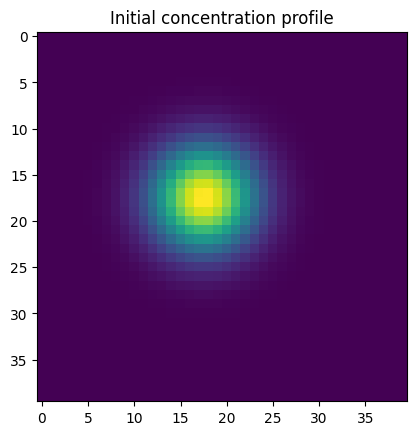

In [6]:
#
# defining initial condition
#
L = 40
def gaussian_on_grid(L, mu_x=0., mu_y=0., sigma=1.):
    x, y = np.meshgrid(np.linspace(-1,1, L), np.linspace(-1,1,L))
    x += mu_x
    y += mu_y
    d = np.sqrt(x*x+y*y)
    return np.exp(-( d**2 / ( 2.0 * sigma**2 ) ) )

c_init = gaussian_on_grid(L, 0.1, 0.1, sigma=0.2)
plt.imshow(c_init)
plt.title("Initial concentration profile")

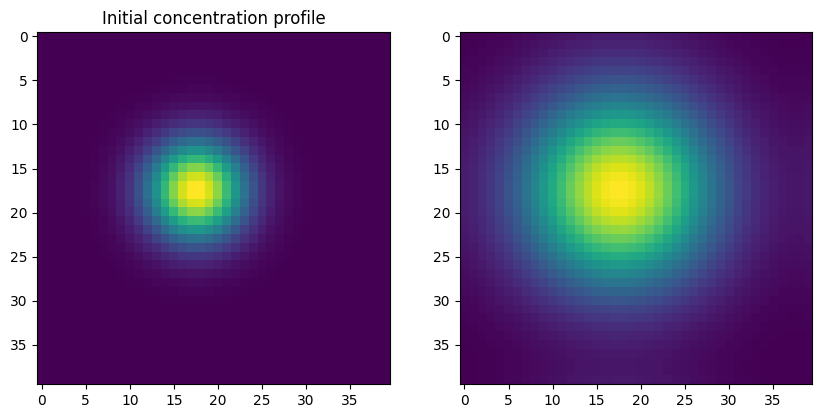

In [7]:
#
# simulation code
#
def diffusion_pbc(c):# Periodic b.c.
    return jnp.roll(c, 1, axis=0) + jnp.roll(c, -1, axis=0) + jnp.roll(c, 1, axis=1) + jnp.roll(c, -1, axis=1) - 4*c

@partial(jit, static_argnums=(4, 5))
def update_by_scan(c, D, dt, dx, length, update_func):
    def scan_fn(carry, _):
        carry = carry + dt / dx / dx * D * update_func(carry)
        return carry, None
    c_new, _ = jax.lax.scan(scan_fn, c, xs=None, length=length)
    return c_new # length-times-update c field

D_data = 4.3
num_t = 500
dt = 0.01
dx = 1.0

c_new = update_by_scan(c_init, D_data, dt, dx, num_t, diffusion_pbc)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(c_init)
ax[0].set_title("Initial concentration profile")
ax[1].imshow(c_new)

In [8]:
#
# defining loss function
#
def ssd(x, y):
    return jnp.sum((x - y)**2)

def simulation_loss(c0, c_target, D, dt, dx, num_t, update_func):
    c_sim = update_by_scan(c0, D, dt, dx, num_t, update_func)
    return ssd(c_target, c_sim)

print(simulation_loss(c_init, c_new, 1.0, dt, dx, num_t, diffusion_pbc))
print(simulation_loss(c_init, c_new, D_data, dt, dx, num_t, diffusion_pbc))

6.5266514
0.0


1 th epoch..., D = 2.4553
10 th epoch..., D = 3.7329
20 th epoch..., D = 4.0777
30 th epoch..., D = 4.2055
Estimated D: 4.2055, True D: 4.3


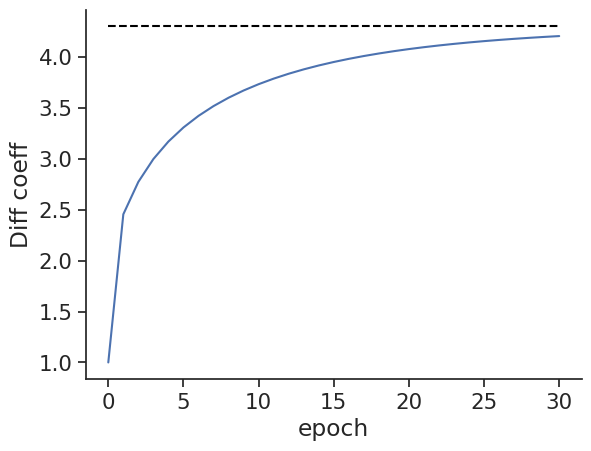

In [9]:
#
# Parameter optimization by steepest gradient descent
#
n_epoch = 30
D_init = 1.0
D_current = D_init
Ds = [D_init]
lr = 0.2
for epoch in range(1, n_epoch+1):
    loss, D_grad = jax.value_and_grad(simulation_loss, argnums=2, has_aux=False)(c_init, c_new, D_current, dt, dx, num_t, diffusion_pbc)
    D_current = D_current - lr*D_grad
    Ds.append(D_current)
    if epoch%10 == 0 or epoch == 1:
        print(f"{epoch} th epoch..., D = {D_current:.4f}")
Ds = np.array(Ds)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.4, rc=custom_params)
plt.plot(Ds)
plt.hlines(D_data, 0, n_epoch, linestyles='dashed', color='black')
plt.xlabel('epoch')
plt.ylabel('Diff coeff')
print(f"Estimated D: {D_current:.4f}, True D: {D_data}")

1 th epoch..., D = 1.9049
10 th epoch..., D = 4.3000
20 th epoch..., D = 4.3000
30 th epoch..., D = 4.3000
Estimated D: 4.3000, True D: 4.3


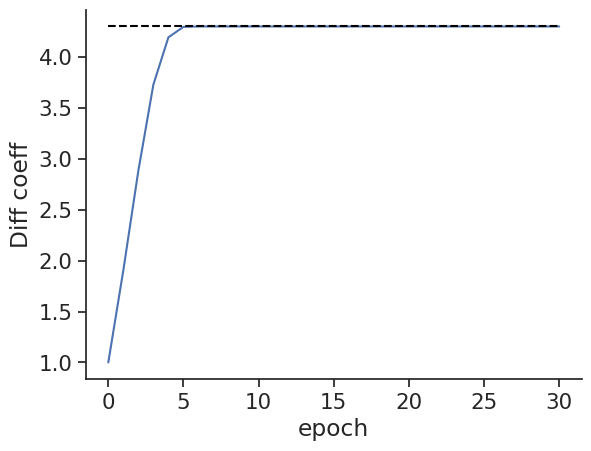

In [10]:
#
# Parameter optimization by Newton's method
#
def update_diff_newton(c0, c_target, D, dt, dx, num_t, update_func):
    grad_loss = grad(simulation_loss, argnums=2, has_aux=False)
    grad_grad_loss = grad(grad_loss, argnums=2, has_aux=False)
    D_grad = grad_loss(c0, c_target, D, dt, dx, num_t, update_func)
    D_grad_grad = grad_grad_loss(c0, c_target, D, dt, dx, num_t, update_func)
    return D - D_grad/D_grad_grad

n_epoch = 30
D_init = 1.0
D_current = D_init
Ds = [D_init]
for epoch in range(1, n_epoch+1):
    D_current = update_diff_newton(c_init, c_new, D_current, dt, dx, num_t, diffusion_pbc)
    Ds.append(D_current)
    if epoch%10 == 0 or epoch == 1:
        print(f"{epoch} th epoch..., D = {D_current:.4f}")
Ds = np.array(Ds)

plt.plot(Ds)
plt.hlines(D_data, 0, n_epoch, linestyles='dashed', color='black')
plt.xlabel('epoch')
plt.ylabel('Diff coeff')
print(f"Estimated D: {D_current:.4f}, True D: {D_data}")

1 th epoch..., D = 1.2000
10 th epoch..., D = 2.7852
20 th epoch..., D = 3.8871
30 th epoch..., D = 4.4174
40 th epoch..., D = 4.5992
50 th epoch..., D = 4.5981
60 th epoch..., D = 4.5194
70 th epoch..., D = 4.4258
80 th epoch..., D = 4.3504
90 th epoch..., D = 4.3048
100 th epoch..., D = 4.2863


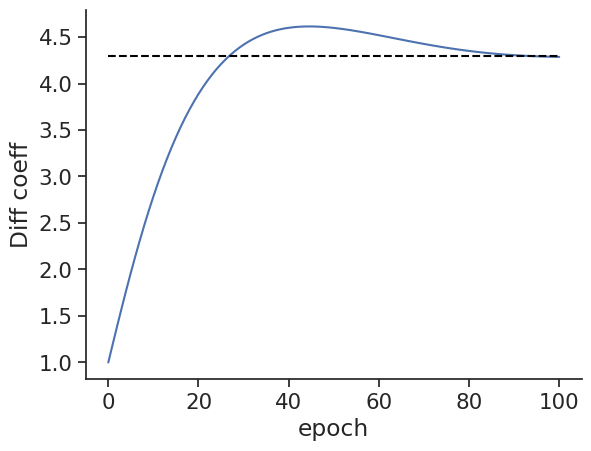

Estimated D: 4.2863, True D: 4.3


In [11]:
#
# Parameter optimization by Adam
#
import optax

n_epoch = 100
D_init = 1.0
lr = 0.2

D_current = jnp.array(D_init)
Ds = [D_current]

optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(D_current)

def step(D, c_init, c_new, dt, dx, num_t, diffusion_pbc):
    loss, D_grad = jax.value_and_grad(simulation_loss, argnums=2, has_aux=False)(
        c_init, c_new, D, dt, dx, num_t, diffusion_pbc
    )
    return loss, D_grad
fixed_args = (c_init, c_new, dt, dx, num_t, diffusion_pbc)

for epoch in range(1, n_epoch + 1):
    loss, D_grad = step(D_current, *fixed_args)

    updates, opt_state = optimizer.update(D_grad, opt_state)
    D_current = optax.apply_updates(D_current, updates)

    Ds.append(D_current)

    if epoch % 10 == 0 or epoch == 1:
        print(f"{epoch} th epoch..., D = {D_current:.4f}")

Ds = np.array(Ds)

plt.plot(Ds)
plt.hlines(D_data, 0, n_epoch, linestyles='dashed', color='black')
plt.xlabel('epoch')
plt.ylabel('Diff coeff')
plt.show()

print(f"Estimated D: {D_current:.4f}, True D: {D_data}")